# Lab1 - Assignment

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# 1. Load CIFAR10
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 5. Use some data augmentation for the training set -- RandomCrop(224) and RandomHorizontalFlip() seem to help.
# 6. Normalize the images to the [-1,1] range using Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) if you're training from scratch, or if you're fine tuning the ImageNet weights, you should probably use the magic normalizer of Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), though this can give pixel values outside the [-1,1] range.
preprocess = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 1. Use the torchvision CIFAR10 dataset to download the data and load images into memory
# 2. Use PyTorch Dataloaders to shuffle the data and break them into batches during training
# 3. Use a batch size of 200 or less so that you're not using more than 3 GB of GPU RAM (save some for others!)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False, num_workers=0)

classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

Files already downloaded and verified
Files already downloaded and verified


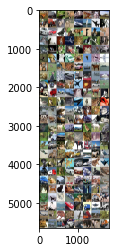

tensor([4, 9, 6, 4, 9, 6, 7, 0, 7, 9, 5, 7, 8, 8, 0, 3, 1, 1, 5, 3, 7, 2, 9, 3,
        4, 3, 5, 0, 4, 5, 2, 3, 1, 7, 3, 9, 3, 3, 2, 0, 4, 2, 5, 1, 4, 2, 2, 0,
        7, 4, 3, 6, 1, 8, 7, 8, 3, 4, 3, 9, 9, 3, 8, 8, 2, 1, 9, 7, 0, 6, 1, 4,
        9, 9, 0, 9, 5, 7, 7, 7, 2, 2, 5, 3, 0, 5, 6, 2, 8, 3, 6, 0, 9, 3, 5, 8,
        3, 6, 1, 5, 5, 9, 3, 1, 4, 8, 7, 1, 0, 2, 7, 2, 4, 9, 0, 4, 3, 4, 3, 3,
        2, 1, 5, 6, 7, 9, 8, 7, 0, 5, 4, 4, 1, 8, 7, 2, 2, 2, 7, 6, 1, 8, 6, 0,
        9, 9, 4, 1, 9, 8, 3, 2, 1, 6, 1, 3, 9, 1, 4, 4, 3, 5, 3, 4, 1, 0, 7, 7,
        6, 0, 0, 1, 4, 4, 1, 7, 9, 9, 8, 8, 6, 9, 0, 0, 0, 2, 6, 6, 0, 9, 7, 6,
        6, 0, 9, 1, 6, 5, 3, 9]) ['deer' 'truck' 'frog' 'deer' 'truck' 'frog' 'horse' 'plane' 'horse'
 'truck' 'dog' 'horse' 'ship' 'ship' 'plane' 'cat' 'car' 'car' 'dog' 'cat'
 'horse' 'bird' 'truck' 'cat' 'deer' 'cat' 'dog' 'plane' 'deer' 'dog'
 'bird' 'cat' 'car' 'horse' 'cat' 'truck' 'cat' 'cat' 'bird' 'plane'
 'deer' 'bird' 'dog' 'car' 'deer' 'bird' 'bi

In [3]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

toshow = torchvision.utils.make_grid(images)
toshow = toshow / 2 + 0.5     # unnormalize
npimg = toshow.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(labels, classes[labels])

In [4]:
# 2. Load AlexNet
# https://github.com/pytorch/vision/releases
# The newest version isa 0.8.2 and load empty model
model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=False)
print(model.eval())

# https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
#Updating the second classifier
# AlexNet_model.classifier[4] = nn.Linear(4096,1024)
#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(4096,10)
print(model.eval())

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.2
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)

In [5]:
# move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
# 4. For the optimizer, use stochastic gradient descent with a learning rate around 0.01 or 0.02 to start with. I couldn't get the Adam optimizer working in this experiment at all.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
losses = []
counter = 0
counter_2000 = 0
# 7. Use tensorboard to monitor training, it's awesome!
writer = SummaryWriter()
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Log input to tensorboard
        grid = torchvision.utils.make_grid(inputs)
        writer.add_image('images', grid, i)
        writer.add_graph(model, images)
        writer.close()
        
        # print(i)
        # if(i == 4):
        #     raise ValueError(f"stop ka")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # writer.add_scalar('pureLoss/train', loss.item(), counter)
        if i % 1000 == 999:    # print every 2000 mini-batches
            torch.save(model.state_dict(), (f'checkpoints/alexnet-cifar-10-{epoch}-{i}-epochs-sgd-0.0001.pth'))
            # losses.append(running_loss / 2000)
            writer.add_scalar('1000Loss/train', running_loss / 2000, counter_2000)
            counter_2000 = counter_2000 + 1
            running_loss = 0.0
        counter = counter + 1

print('Finished Training of AlexNet')
# save looses
with open("losses.txt", "wb") as f:   #Pickling
    pickle.dump(losses, f)
# save model
torch.save(model, "alextrain.model")

0
1
2
3
4


ValueError: stop ka

In [ ]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

In [ ]:
# # save model
# torch.save(model, "alextrain.model")
# # save looses
# with open("losses.txt", "wb") as f:   #Pickling
#     pickle.dump(losses, f)

# Multiple GPU

In [ ]:
# import torch
# import torchvision
# import torchvision.transforms as transforms

# import matplotlib.pyplot as plt
# import numpy as np

# import torch.optim as optim
# import torch.nn as nn

# # 1. Load dataset
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# # rand_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

# # 2. Load AlexNet
# import torch
# import torch.nn as nn
# model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=False)
# model.classifier[6] = nn.Linear(4096,10)

# #Loss
# criterion = nn.CrossEntropyLoss()
# #Optimizer(SGD)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#   model = nn.DataParallel(model, device_ids=[0,1,2])

# model.to(device)
# for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # print("Outside: input size", inputs.size())
#         # 1 GPUs Outside: input size torch.Size([4, 3, 224, 224])
#         # 2 GPUs Outside: input size torch.Size([4, 3, 224, 224])
#         # 3 GPUs Outside: input size torch.Size([4, 3, 224, 224])
#         # output_size torch.Size([4, 10])
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         output = model(inputs)
#         # print("output_size", output.size())
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 10 == 0:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training of AlexNet')